<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [39]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt
from scipy.stats import bernoulli, beta 

In [40]:
df=pd.read_csv('./data/cookie_cats.csv')


In [41]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [42]:
df.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [43]:
df30=df[df.version=='gate_30']
df30

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
13,2179,gate_30,39,True,False
...,...,...,...,...,...
90179,9998576,gate_30,14,True,False
90180,9998623,gate_30,7,False,False
90182,9999178,gate_30,21,True,False
90183,9999349,gate_30,10,False,False


In [44]:
df40=df[df.version=='gate_40']
df40

,userid,version,sum_gamerounds,retention_1,retention_7
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
7,1444,gate_40,2,False,False
...,...,...,...,...,...
90181,9998733,gate_40,10,True,False
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90187,9999768,gate_40,51,True,False


In [45]:
df30_1=df30[df30.retention_1==True]['retention_1'].sum()
df30_1

20034

In [50]:
df40_1=df40[df40.retention_1==True]['retention_1'].sum()
df40_1

20119

In [51]:
#Retention 1

imps_g30_1, ret1_g30 = 44700, 20034
imps_g40_1, ret1_g40 = 45489, 20119


CR_g30=ret1_g30/imps_g30
CR_g40=ret1_g40/imps_g40

f'TASAS: Control={CR_g30}, Test={CR_g40}'

In [52]:
beta_g30_1=beta(ret1_g30+1, imps_g30-ret1_g30+1)
beta_g40_1=beta(ret1_g40+1, imps_g40-ret1_g40+1)

In [54]:
beta_g30_1.mean(), beta_g40_1.mean()

(0.44819023757326293, 0.44228528719966587)

In [56]:
x=np.linspace(0.4, 0.5, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

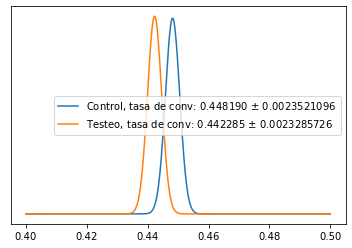

In [65]:
plot([beta_g30_1, beta_g40_1], ['Control', 'Testeo'])


In [70]:
salto=(beta_g40_1.mean()-beta_g30_1.mean())/beta_g30_1.mean()

salto

-0.013175098158249857

In [72]:
from mpmath import betainc   # integral de beta

prob=beta.cdf(0.444, ret1_g40+1, imps_g40-ret1_g40+1)

prob=float(prob)

prob

0.7692976408850918

In [73]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test aumenta la tasa de conversion en un -1.32%, con una probabilidad del 76.93%'

In [ ]:
#Retention 7

In [59]:
df30_7=df30[df30.retention_7==True]['retention_7'].sum()
df30_7

8502

In [60]:
df40_7=df40[df40.retention_7==True]['retention_7'].sum()
df40_7

8279

In [61]:
imps_g30_7, ret7_g30 = 44700, 8502
imps_g40_7, ret7_g40 = 45489, 8279


In [62]:
beta_g30_7=beta(ret7_g30+1, imps_g30-ret7_g30+1)
beta_g40_7=beta(ret7_g40+1, imps_g40-ret7_g40+1)

In [64]:
beta_g30_7.mean(), beta_g40_7.mean()

(0.19021520289919913, 0.18201402475214878)

In [67]:
x=np.linspace(0.17, 0.2, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

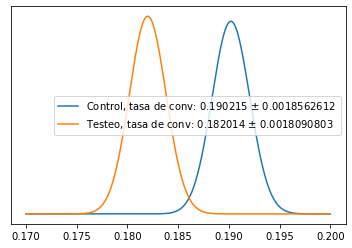

In [68]:
plot([beta_g30_7, beta_g40_7], ['Control', 'Testeo'])


In [74]:
salto=(beta_g40_7.mean()-beta_g30_7.mean())/beta_g30_7.mean()

salto

-0.04311526114658881

In [76]:
prob=beta.cdf(0.186, ret7_g40+1, imps_g40-ret7_g40+1)

prob=float(prob)

prob

0.9858653005312228

In [78]:
'''El test disminuye la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test disminuye la tasa de conversion en un -4.31%, con una probabilidad del 98.59%'